# Task: Neural Ordinary Differential Equations
#### Non-linear Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Content creators: Dr.-Ing. Maximilian Kannapin

Summer term 2024

---

#### In this notebook, you learn...

*

*Run the following cells to install and import the required dependencies.*

In [17]:
# %% Imports
import time

import numpy
import numpy as np
import diffrax
from diffrax import backward_hermite_coefficients, CubicInterpolation
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import os
from tqdm import tqdm
import numpy as np

## Introduction to Neural Ordinary Differential Equations (Neural ODEs)

### Ordinary Differential Equations (ODEs)

Ordinary Differential Equations (ODEs) are equations that describe the relationship between a function and its derivatives and are typically written in the form:
$$
\[\frac{dy(t)}{dt} = f(t, y(t)) \]
$$
where $\( y(t) \)$ is the state of the system at time $\( t \)$, and $\( f(t, y(t)) \)$ is a function that describes the dynamics of the system.

### Neural Ordinary Differential Equations (NODEs)

Owing to the fact that Ordinary Differential Equations are a continuous functions, Neural ODEs leverage this behaviour to model complex dynamical systems. Instead of using discrete layers like traditional Neural Networks or Residual Networks, Neural ODEs use a Neural Network to parameterize the function $f$ as an Ordinary Differential Equation.

>insert image of ResNet (intermittent) vs NODE (continuous) from Chen et. al.<

Given an initial state $\( y(t_0) = y_0 \)$, the evolution of the state over time can be described by solving the ODE:

$$\[ y(t) = y_0 + \int_{t_0}^{t} f(y(t), t, \theta) dt \]$$

where $\( \theta \)$ represents the parameters of the neural network, and $y_0 \in \mathbb{R}^n$.

Simply put, we need the dynamics function to accept the current state $y(t)$ of the ODE at current time $t$ and parameters $\theta$, to give an output $\frac{\partial(y(t))}{\partial(t)}$ that has the same shape as $y(t)$

Let's take a look at how to define such a class of machine learning models using Google JAX

In [18]:
class NeuralODE(eqx.Module):
    mlp: eqx.nn.MLP
    time_dependent: bool
    state_size: int
    augmentation_size: int
    input_size: int

    def __init__(self, state_size, augmentation_size=0, input_size=0, time_dependent=False, nn_width=16, nn_depth=2, *,
                 key, **kwargs):
        super().__init__(**kwargs)

        nn_in_size = state_size + augmentation_size + input_size + time_dependent
        nn_out_size = state_size + augmentation_size

        self.state_size = state_size
        self.time_dependent = time_dependent
        self.augmentation_size = augmentation_size
        self.input_size = input_size

        self.mlp = eqx.nn.MLP(
            in_size=nn_in_size,
            out_size=nn_out_size,
            width_size=nn_width,
            depth=nn_depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, ts, y0, us):

        y0 = jnp.pad(y0, (0, self.augmentation_size))

        if self.input_size:
            coeffs = backward_hermite_coefficients(ts, us)
            interp = CubicInterpolation(ts, coeffs)
        else:
            interp = None

        def func(t, y, interp):
            if self.input_size:
                u = interp.evaluate(t)
            else:
                u = jnp.empty(shape=(0,))

            if self.time_dependent:
                t = jnp.expand_dims(t, axis=0)
            else:
                t = jnp.empty(shape=(0,))

            nn_input = jnp.concat([y, u, t], axis=0)
            return self.mlp(nn_input)

        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(func),
            diffrax.Dopri5(),
            t0=ts[0], t1=ts[-1],
            dt0=ts[1] - ts[0], y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
            args=interp,
        )
        return solution.ys[:, :self.state_size]

In the above, we have defined, a Neural ODE model that adapts to the size of the data that is being provided.  We are using a Dormand-Prince Solver, which is an adaptive step-size solver. The adaptive step size control is achieved using a PID Controller where the relative tolerance (`rtol`) and absolute tolerance (`atol`). The PID controller can further be tweaked using the PID coefficients (`pcoeff`, `icoeff` and `dcoeff`) or even by adding minnimum and maximum step size (`dtmin` and `dtmax`)

For now, we ignore the statements relating to augmentations. It defaults to 0, which means no augmentations will take place.

## Data Preparation

A parameter-sweep is performed on the Non-linear Euler-Bernoulli beam model on MATLAB to generate data for training.

The following function imports the necessary data and prepares it to be used with the model, for training and inference.

In [19]:
def dataprep(datafile, node):
    def create_path(i):
        filename = [filename for filename in os.listdir('nlebb-training-data/') if filename.startswith(str(i))][0]
        path1 = "nlebb-training-data/"
        path2 = filename

        return path1 + path2 + "/" + path2 + "_exc.csv", path1 + path2 + "/" + path2 + "_out.csv"

    def load_data(data_list, nodes):
        inp = np.empty((len(data_list), 2502, 2))
        out = np.empty((len(data_list), 2502, len(nodes)))

        for i in range(len(data_list)):
            exc, outt = create_path(data_list[i])
            inp[i] = np.loadtxt(open(exc), delimiter=',', skiprows=1)
            out[i] = np.loadtxt(open(outt), delimiter=',', skiprows=1, usecols=(nodes))

        return inp, out

    inp_tr, out_tr = load_data(datafile, node)
    us = np.expand_dims(inp_tr[:, :, 1],-1)
    ys = out_tr
    ts = inp_tr[:, :, 0]
    ts = np.squeeze(ts[0])
    return us, ys, ts

We can now define the parameters for the model and its training

In [20]:
datafile = [2100, 2105, 2130, 2135]
#datafile = np.arange(2100, 2136, 1)
node = [34, 36]    # The z-axis displacement of the final node and its derivative w.r.t time
aug_dim = 0
hidden_layers = 2
hidden_dims = 32
learning_rate = 0.001
Epochs = 20000
print_every = 100
validation_dataset = np.arange(2100, 2136, 1)
optim = optax.adabelief(learning_rate)
seed = 42         # Seed for a pseudo-random function which initializes parameters of the Neural Network

In [21]:
us_train, ys_train, ts_train = dataprep(datafile, node)       # Training data
us, ys, ts = dataprep(datafile, node)
us_val, ys_val, ts_val = dataprep(validation_dataset, node)  # Validation data
num_ts = ts_train.size
key = jr.PRNGKey(seed)
model_key, key = jr.split(key, 2)

Further, let's also define functions that obtain loss, gradient and update the weights accordingly.

In [22]:
def _dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = min(batch_size, dataset_size)
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

@eqx.filter_jit
def get_loss(model, ti, yi, ui):
    y_pred = jax.vmap(model, in_axes=(None, 0, 0))(ti, yi[:, 0], ui)
    return jnp.mean((yi - y_pred) ** 2)

grad_loss = eqx.filter_value_and_grad(get_loss)

@eqx.filter_jit
def make_step(ti, yi, ui, model, optim, opt_state):
    loss, grads = grad_loss(model, ti, yi, ui)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def train(
    model,
    training_data,
    key,
    validation_data,
    batch_size=32,
    lr_strategy=(3e-3, 1e-3),
    steps_strategy=(500, 1000),
    length_strategy=(0.1, 1),
    print_every=100,):

    ts, ys, us = training_data
    vts, vys, vus = validation_data

    num_ts = ts.shape[0]
    losses = []
    val_losses = []

    start_time = time.time()
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[:   int(num_ts * length)]
        _ys = ys[:, :int(num_ts * length)]
        _us = us[:, :int(num_ts * length)]
        _vts = vts[:   int(num_ts * length)]
        _vys = vys[:, :int(num_ts * length)]
        _vus = vus[:, :int(num_ts * length)]
        for step, (yi, ui) in zip(
            range(steps), _dataloader((_ys, _us), batch_size, key=key)
        ):
            loss, model, opt_state = make_step(_ts, yi, ui, model, optim, opt_state)
            val_loss = get_loss(model, _vts, _vys, _vus)
            losses.append(loss)
            val_losses.append(val_loss)
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss:.3e}, Val Loss: {val_loss:.3e}")
    training_time = time.time() - start_time
    print(f'Training took: {training_time:-2f}s')

    return model, losses, val_losses

The model can now be trained

In [23]:
model = NeuralODE(state_size=ys.shape[-1],
                      input_size=us.shape[-1], 
                      time_dependent=False, 
                      nn_width=hidden_dims, nn_depth=hidden_layers, 
                      key=model_key)
model, losses, val_losses = train(
        model, (ts_train, ys_train, us_train), key, validation_data=(ts_val, ys_val, us_val), batch_size=len(ys), 
        steps_strategy=(Epochs,), length_strategy=(0.5, ), lr_strategy=(learning_rate, )
    )

Step: 0, Loss: 1.240e-01, Val Loss: 2.483e-02
Step: 100, Loss: 5.705e-03, Val Loss: 4.913e-03
Step: 200, Loss: 5.708e-03, Val Loss: 5.079e-03
Step: 300, Loss: 5.687e-03, Val Loss: 5.030e-03
Step: 400, Loss: 5.684e-03, Val Loss: 5.077e-03
Step: 500, Loss: 5.705e-03, Val Loss: 5.040e-03
Step: 600, Loss: 5.687e-03, Val Loss: 5.264e-03
Step: 700, Loss: 5.657e-03, Val Loss: 5.301e-03
Step: 800, Loss: 5.658e-03, Val Loss: 5.151e-03
Step: 900, Loss: 5.687e-03, Val Loss: 5.138e-03
Step: 1000, Loss: 5.673e-03, Val Loss: 4.774e-03
Step: 1100, Loss: 5.663e-03, Val Loss: 4.743e-03
Step: 1200, Loss: 5.679e-03, Val Loss: 4.594e-03
Step: 1300, Loss: 5.665e-03, Val Loss: 4.685e-03
Step: 1400, Loss: 5.659e-03, Val Loss: 4.508e-03
Step: 1500, Loss: 5.626e-03, Val Loss: 4.628e-03
Step: 1600, Loss: 5.667e-03, Val Loss: 4.470e-03
Step: 1700, Loss: 5.640e-03, Val Loss: 4.512e-03
Step: 1800, Loss: 5.642e-03, Val Loss: 4.602e-03
Step: 1900, Loss: 5.641e-03, Val Loss: 4.561e-03
Step: 2000, Loss: 5.721e-03, Val

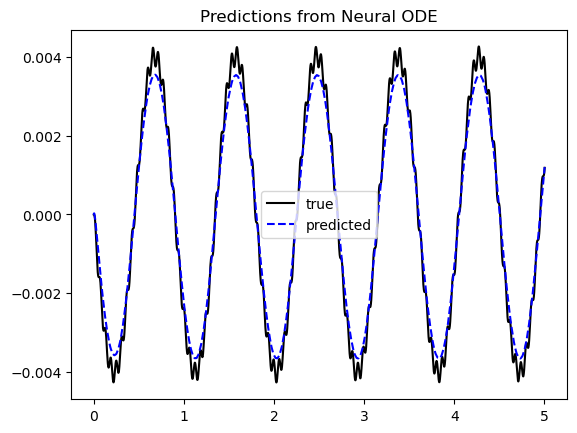

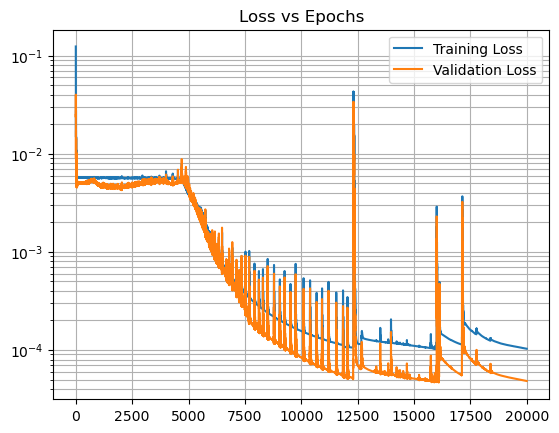

In [25]:
testset = [2102]
tus, tys, tts = dataprep(testset, node)
y_pred = jax.vmap(model, in_axes=(None, 0, 0))(tts, tys[:, 0], tus)

plt.figure()
plt.plot(tts, tys[0, :, 0], color='black', label='true', alpha = 1)
plt.plot(tts , y_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
plt.legend()
plt.title('Predictions from Neural ODE')
plt.show()

plt.figure()
plt.semilogy(losses, label="Training Loss")
plt.semilogy(val_losses, label = "Validation Loss")
plt.legend()
plt.grid(which = 'both')
plt.title("Loss vs Epochs")
plt.show()


In [28]:
te = np.arange(2100, 2136, 1)
for i in range (len(te)):
    plt.figure()
    ttus, ttys, ttts = dataprep([te[i]], node)
    ty_pred = jax.vmap(model, in_axes=(None, 0, 0))(ttts, ttys[:, 0], ttus)
    plt.plot(ttts, ttys[0, :, 0], color='black', label='true', alpha = 1)
    plt.plot(ttts , ty_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
    plt.legend()
    plt.title('Predictions from Neural ODE')
    plt.savefig(f"ResultsJAX/neuralODE_Zlast/trAllte{te[i]}.png")
    plt.close()
    

### Advantages of Neural ODEs

* Continuous-Time Modeling: They provide a natural way to model systems that evolve continuously over time.  Unlike ResNets, the data does not have to be modelled in fixed time steps.

* Adaptive computation: They allow for adaptive time-stepping during training and inference, potentially leading to more efficient computation.

* Memory efficiency: They can be more memory efficient than traditional neural networks as they do not store intermediate activations, but rather a continuous function

### Limitations

* Limited Expressive Power: Neural ODEs can struggle with representing complex, high-dimensional dynamics, especially when the underlying system exhibits intricate behaviors that a standard ODE might find hard to capture.

* Gradient Flow: During training, Neural ODEs can suffer from vanishing or exploding gradients, which hampers their ability to learn effectively, especially for long sequences or deep networks. 

* Representation of Discontinuous Dynamics: Neural ODEs are inherently continuous and may struggle with systems that have discontinuities or sharp transitions. 

* Intersecting Trajectories: For a given an initial condition, the solution to the ODE is unique, and this trait is inherited by Neural ODEs. Therefore systems that have intersecting trajectory evolution cannot be represented accurately by Neural ODE models.

>insert image of ResNet vs NODE intersecting trajectory problem from Dupont et.al.<


## Augmented Neural Ordinary Differential Equations (ANODE)

Augmented Neural ODEs address this limitation by introducing additional dimensions to the state space. This augmentation allows the model to learn more complex dynamics and capture finer details. This is achieved by allowing the trajectories to "flow" into the augmented dimensions, to avoid intersecting.

If the original state is $\( y(t) \in \mathbb{R}^n \)$, the augmented state is $\( (y(t), z(t)) \in \mathbb{R}^{n+m} \)$, where $\( z(t) \)$ represents the additional dimensions.  Hence, the general form of an Augmented Neural ODE can be written as:

$$\[ \frac{d}{dt} \begin{pmatrix} y(t) \\ z(t) \end{pmatrix} = f\left( t, \begin{pmatrix} y(t) \\ z(t) \end{pmatrix}, \theta \right) \]$$

The initial augmented state $\( (y(t_0), z(t_0)) \)$ is typically initialized with $\( z(t_0) = 0 \)$ or some other values that reflect prior knowledge about the system.


### Definition of an Augmented Neural ODE

Similar to NODEs, we now define the parameters for the model and training, with an additional parameter for augmented dimensions

In [34]:
datafile = [2100, 2105, 2130, 2135]
#datafile = np.arange(2100, 2136, 1)
node = [34, 36]    # The z-axis displacement of the final node and its derivative w.r.t time
aug_dim = 1
hidden_layers = 2
hidden_dims = 32
learning_rate = 0.001
Epochs = 30000
print_every = 100
validation_dataset = np.arange(2100, 2136, 1)
optim = optax.adabelief(learning_rate)
seed = 42         # Seed for a pseudo-random function which initializes parameters of the Neural Network

In [35]:
us_train, ys_train, ts_train = dataprep(datafile, node)       # Training data
us, ys, ts = dataprep(datafile, node)
us_val, ys_val, ts_val = dataprep(validation_dataset, node)  # Validation data
num_ts = ts_train.size
key = jr.PRNGKey(seed)
model_key, key = jr.split(key, 2)

In [36]:
model = NeuralODE(state_size=ys.shape[-1],
                      input_size=us.shape[-1], 
                      time_dependent=False, 
                      nn_width=hidden_dims, nn_depth=hidden_layers, 
                      key=model_key, augmentation_size=aug_dim)
model, losses, val_losses = train(
        model, (ts_train, ys_train, us_train), key, validation_data=(ts_val, ys_val, us_val), batch_size=len(ys[0]), 
        steps_strategy=(Epochs,), length_strategy=(0.5, ), lr_strategy=(learning_rate, )
    )

Step: 0, Loss: 4.658e-01, Val Loss: 2.197e-01
Step: 100, Loss: 5.654e-03, Val Loss: 4.160e-03
Step: 200, Loss: 5.618e-03, Val Loss: 4.141e-03
Step: 300, Loss: 5.607e-03, Val Loss: 4.112e-03
Step: 400, Loss: 5.549e-03, Val Loss: 4.101e-03
Step: 500, Loss: 5.475e-03, Val Loss: 4.087e-03
Step: 600, Loss: 5.376e-03, Val Loss: 4.090e-03
Step: 700, Loss: 5.224e-03, Val Loss: 4.059e-03
Step: 800, Loss: 5.152e-03, Val Loss: 4.085e-03
Step: 900, Loss: 5.095e-03, Val Loss: 4.103e-03
Step: 1000, Loss: 5.070e-03, Val Loss: 4.173e-03
Step: 1100, Loss: 5.048e-03, Val Loss: 4.283e-03
Step: 1200, Loss: 5.012e-03, Val Loss: 4.455e-03
Step: 1300, Loss: 4.962e-03, Val Loss: 4.581e-03
Step: 1400, Loss: 4.928e-03, Val Loss: 4.620e-03
Step: 1500, Loss: 4.803e-03, Val Loss: 4.642e-03
Step: 1600, Loss: 4.505e-03, Val Loss: 4.481e-03
Step: 1700, Loss: 3.717e-03, Val Loss: 3.689e-03
Step: 1800, Loss: 3.425e-03, Val Loss: 3.295e-03
Step: 1900, Loss: 3.323e-03, Val Loss: 3.119e-03
Step: 2000, Loss: 3.291e-03, Val

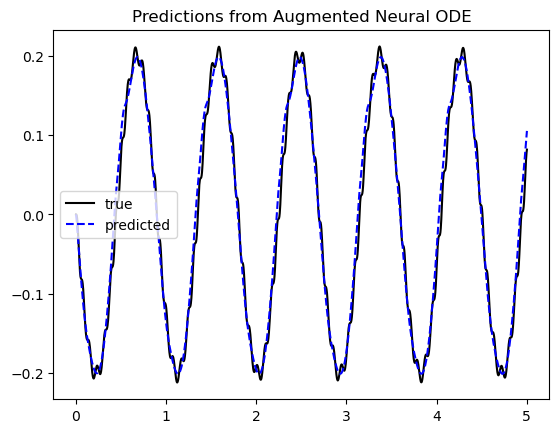

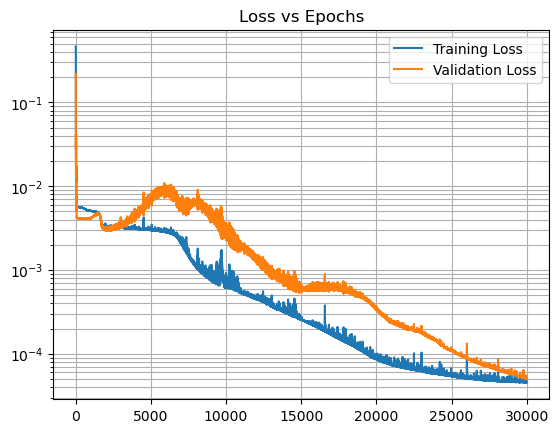

In [37]:
testset = [2132]
tus, tys, tts = dataprep(testset, node)
y_pred = jax.vmap(model, in_axes=(None, 0, 0))(tts, tys[:, 0], tus)

plt.figure()
plt.plot(tts, tys[0, :, 0], color='black', label='true', alpha = 1)
plt.plot(tts , y_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
plt.legend()
plt.title('Predictions from Augmented Neural ODE')
plt.show()

plt.figure()
plt.semilogy(losses, label="Training Loss")
plt.semilogy(val_losses, label = "Validation Loss")
plt.legend()
plt.grid(which = 'both')
plt.title("Loss vs Epochs")
plt.show()

In [39]:
te = np.arange(2100, 2136, 1)
for i in range (len(te)):
    plt.figure()
    ttus, ttys, ttts = dataprep([te[i]], node)
    ty_pred = jax.vmap(model, in_axes=(None, 0, 0))(ttts, ttys[:, 0], ttus)
    plt.plot(ttts, ttys[0, :, 0], color='black', label='true', alpha = 1)
    plt.plot(ttts , ty_pred[0, :, 0], color='blue', label='predicted', linestyle = '--')
    plt.legend()
    plt.title('Predictions from Neural ODE')
    plt.savefig(f"ResultsJAX/Aug1neuralODE_Zlast/trAllte{te[i]}.png")
    plt.close()
    

### Advantages of Augmented Neural ODEs

* Better expressiveness: By expanding the state space, the model can capture more complex dynamics with higher accuracy.
* Wider applicability: Augmented Neural ODEs can achieve better results across a range of tasks and even represent cases where Neural ODEs fall short (for example: Intersecting trajectories)

>Add more as necessary<